In [14]:
import os
import sys
import json
import playsound
import torch
import torch.nn as nn
import torchvision
import torchvision.models.segmentation.deeplabv3 as dlv3
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
import numpy as np
import utils
import data
import time
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from PIL import Image

## Training-related functions

In [15]:
def validate_epoch(model, device, val_dataloader, loss_function, num_classes, ignore_label):
    model.eval()
    batch_losses = []
    metrics = {'miou': 0, 'ious': [], 'loss': 0}
    
    with torch.no_grad():
        for (inputs, targets) in val_dataloader:
            start_time = time.time()
            ipts = inputs.to(device, non_blocking=True)# torch.autograd.Variable(inputs).cuda()
            tgts = targets.to(device, non_blocking=True)# torch.autograd.Variable(targets).cuda()
            
            preds = model(ipts)['out']
            loss = loss_function(preds, tgts.squeeze(1).long())
            loss_val = loss.item()
            batch_losses += [loss_val]

            preds = torch.argmax(preds.cpu(), dim=1)
            tgts = torch.squeeze(targets, dim=1)

            miou, ious = utils.measure_performance(preds, tgts, num_classes=num_classes, ignore_label=ignore_label)

            metrics['miou'] += miou
            metrics['loss'] += loss
            
            print(f'Batch validation time: {time.time() - start_time:.5f} s')

        metrics['miou'] /= float(len(val_dataloader))
        metrics['loss'] /= float(len(val_dataloader))
        

    return metrics

In [16]:
def train_epoch(model, device, train_dataloader, loss_function, optimizer):
    model.train()
    batch_losses = []
    
    for (inputs, targets) in train_dataloader:
        start_time = time.time()
        ipts = inputs.to(device, non_blocking=True)# torch.autograd.Variable(inputs).cuda()
        tgts = targets.to(device, non_blocking=True).squeeze(1).long() #tgts = torch.autograd.Variable(targets).cuda().squeeze(1).long()
        pred = model(ipts)['out']

        loss = loss_function(pred, tgts)
        loss_val = loss.item()
        batch_losses += [loss_val]

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        print(f'Batch training time: {time.time() - start_time:.5f} s')
    return batch_losses

In [17]:
def train(model, device, train_dataloader, val_dataloader, epochs, loss_function, optimizer, lr_initial, lr_decay, num_classes_val, ignore_label):
    model.train()
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_val_mious = []
    for epoch in tqdm(range(epochs), desc='Epoch progress'):

        # Training phase
        batch_train_losses = train_epoch(
            model=model, 
            device=device,
            train_dataloader=train_dataloader,
            loss_function=loss_function, 
            optimizer=optimizer)
        
        # Validation phase
        batch_val_metrics = validate_epoch(
            model=model,
            device=device,
            val_dataloader=val_dataloader,
            loss_function=loss_function,
            num_classes=num_classes_val,
            ignore_label=ignore_label)

        epoch_average_train_loss = np.mean(batch_train_losses)
        epoch_train_losses += [epoch_average_train_loss]
        epoch_val_losses += [batch_val_metrics['loss']]
        epoch_val_mious += [batch_val_metrics['miou']]

        print(f'\n[TRAIN] Epoch average loss: {epoch_average_train_loss:.2f}')
        print(f'[VAL] Epoch average loss: {batch_val_metrics["loss"]:.2f}')
        print(f'[VAL] Epoch average miou: {batch_val_metrics["miou"]:.2f}\n')
        
        if lr_decay:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_initial * ((1.0 - (float(epoch) / float(epochs))) ** 0.9)

    return {'epoch_train_losses': epoch_train_losses, 'epoch_val_losses': epoch_val_losses, 'epoch_val_mious': epoch_val_mious}

## Training configuration loading

In [18]:
import pprint
args = {}
with open('G:/My Drive/Master IVA/Master Thesis/Configs/train-config-2.json') as json_file:
    args = json.load(json_file)
pprint.pprint(args)

{'data_batch_size': 8,
 'data_source': 'real',
 'data_subset_size': 80,
 'epochs': 8,
 'fine_tune': False,
 'fine_tune_model_path': 'G:/My Drive/Master IVA/Master '
                         'Thesis/Models/20230403_210427/deeplabv3_model.pt',
 'ignore_label': 19,
 'image_height': 256,
 'image_width': 256,
 'learning_rate': 0.0005,
 'learning_rate_paper_decay': True,
 'model_save_path': 'G:/My Drive/Master IVA/Master Thesis/Models',
 'val_data_batch_size': 8,
 'val_data_subset_size': 24}


## Data loading and preprocessing

In [19]:
torch.cuda.empty_cache()
train_dataset = data.HybridDataset(root_path=f'G:/My Drive/Master IVA/Master Thesis/Datasets/{args["data_source"]}/train',
                                   input_dir='rgb',
                                   target_dir='semantic_segmentation_mapped',
                                   ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                   tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                   type=args["data_source"],
                                   labels_mapping=None)
train_dataset = Subset(train_dataset, indices=range(args["data_subset_size"]))
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=args["data_batch_size"],
                              shuffle=True)
val_dataset = data.HybridDataset(root_path=f'G:/My Drive/Master IVA/Master Thesis/Datasets/{args["data_source"]}/val',
                                 input_dir='rgb',
                                 target_dir='semantic_segmentation_mapped',
                                 ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                 tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                 type=args["data_source"],
                                 labels_mapping=None)
val_dataset = Subset(val_dataset, indices=range(args["val_data_subset_size"]))
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=args["val_data_batch_size"],
                            shuffle=True)
    

In [20]:
train_pixel_sum = torch.tensor([0.0, 0.0, 0.0])
train_pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

for train_inputs, _ in tqdm(train_dataloader, desc='Training dataset norm. params. comp. progress'):
    train_pixel_sum += train_inputs.sum(axis = [0, 2, 3])
    train_pixel_sum_sq += (train_inputs ** 2).sum(axis = [0, 2, 3])

train_pixel_count = args["data_subset_size"] * args["image_width"] * args["image_height"]
train_mean = train_pixel_sum / train_pixel_count
train_variance = (train_pixel_sum_sq / train_pixel_count) - (train_mean ** 2)
train_std = torch.sqrt(train_variance)

print(f'Train dataset \'mean\':{train_mean}')
print(f'Train dataset \'std deviation\':{train_std}')

val_pixel_sum = torch.tensor([0.0, 0.0, 0.0])
val_pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

for val_inputs, _ in tqdm(val_dataloader, desc='Validation dataset norm. params. comp. progress'):
    val_inputs_tensor = torch.tensor(val_inputs)
    val_pixel_sum += val_inputs_tensor.sum(axis = [0, 2, 3])
    val_pixel_sum_sq += (val_inputs_tensor ** 2).sum(axis = [0, 2, 3])

val_pixel_count = args["val_data_subset_size"] * args["image_width"] * args["image_height"]
val_mean = val_pixel_sum / val_pixel_count
val_variance = (val_pixel_sum_sq / val_pixel_count) - (val_mean ** 2)
val_std = torch.sqrt(val_variance)

print(f'Validation dataset \'mean\':{val_mean}')
print(f'Validation dataset \'std deviation\':{val_std}')

Training dataset norm. params. comp. progress: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Train dataset 'mean':tensor([0.2344, 0.2750, 0.2347])
Train dataset 'std deviation':tensor([0.1429, 0.1525, 0.1484])


Validation dataset norm. params. comp. progress:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Manuel\AppData\Local\Temp\ipykernel_2820\3029786214.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs_tensor = torch.tensor(val_inputs)
Validation dataset norm. params. comp. progress: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

Validation dataset 'mean':tensor([0.3364, 0.3708, 0.3299])
Validation dataset 'std deviation':tensor([0.2168, 0.2167, 0.2151])


In [21]:
train_dataset = data.HybridDataset(root_path=f'G:/My Drive/Master IVA/Master Thesis/Datasets/{args["data_source"]}/train',
                                   input_dir='rgb',
                                   target_dir='semantic_segmentation_mapped',
                                   ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                                 torchvision.transforms.Normalize(mean=list(train_mean), std=list(train_std))]),
                                   tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]),
                                   type=args["data_source"],
                                   labels_mapping=None)
train_dataset = Subset(train_dataset, indices=range(args["data_subset_size"]))
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=args["data_batch_size"],
                              shuffle=True, pin_memory=True, num_workers=4)
val_dataset = data.HybridDataset(root_path=f'G:/My Drive/Master IVA/Master Thesis/Datasets/{args["data_source"]}/val',
                                 input_dir='rgb',
                                 target_dir='semantic_segmentation_mapped',
                                 ipt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"])),
                                                                               torchvision.transforms.Normalize(mean=list(val_mean), std=list(val_std))]),
                                 tgt_transform=torchvision.transforms.Compose([torchvision.transforms.Resize((args["image_height"], args["image_width"]))]), 
                                 type=args["data_source"],
                                 labels_mapping=None)
val_dataset = Subset(val_dataset, indices=range(args["val_data_subset_size"]))
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=args["val_data_batch_size"],
                            shuffle=True, pin_memory=True, num_workers=4)

## Training preparation

In [22]:
model = dlv3.deeplabv3_resnet50(weights=None, output_stride=16, progress=True, num_classes=len(data.SemanticLabelMapper.ID_TO_STRING['common'].keys()))
if args["fine_tune"]:
    model.load_state_dict(torch.load(args["fine_tune_model_path"]))
    for name, param in model.backbone.named_parameters():
        if 'layer1' in name or 'layer2' in name or 'layer3' in name or 'layer4' in name or 'layer5' in name:
            param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print('Loaded model to device.')

Loaded model to device.


In [23]:
params = utils.add_weight_decay(model, l2_value=0.0001)
optimizer = torch.optim.Adam(params=params, lr=args["learning_rate"])
loss_function = nn.CrossEntropyLoss()

## Train start

In [25]:
torch.backends.cudnn.benchmark = True
train_metrics = train(model=model,
                      device=device,
                      train_dataloader=train_dataloader, 
                      val_dataloader=val_dataloader, 
                      epochs=args["epochs"], 
                      loss_function=loss_function, 
                      optimizer=optimizer, 
                      lr_initial=args["learning_rate"],
                      lr_decay=args["learning_rate_paper_decay"],
                      num_classes_val=len(data.SemanticLabelMapper.ID_TO_STRING['common'].keys()),
                      ignore_label=None)

Epoch progress:   0%|          | 0/8 [00:00<?, ?it/s]

Batch training time: 0.45050 s
Batch training time: 0.28806 s
Batch training time: 0.28507 s
Batch training time: 0.28706 s
Batch training time: 0.28106 s
Batch training time: 0.29007 s
Batch training time: 0.29107 s
Batch training time: 0.28414 s
Batch training time: 0.29106 s
Batch training time: 0.28606 s
Batch validation time: 0.44910 s
Batch validation time: 0.18304 s
Batch validation time: 0.17515 s


Epoch progress:  12%|█▎        | 1/8 [00:11<01:17, 11.12s/it]


[TRAIN] Epoch average loss: 1.42
[VAL] Epoch average loss: 1.06
[VAL] Epoch average miou: 0.15

Batch training time: 0.40127 s
Batch training time: 0.29907 s
Batch training time: 0.27806 s
Batch training time: 0.28716 s
Batch training time: 0.27706 s
Batch training time: 0.28906 s
Batch training time: 0.28907 s
Batch training time: 0.28506 s
Batch training time: 0.28604 s
Batch training time: 0.28806 s
Batch validation time: 0.44310 s
Batch validation time: 0.18004 s
Batch validation time: 0.17504 s


Epoch progress:  25%|██▌       | 2/8 [00:22<01:06, 11.04s/it]


[TRAIN] Epoch average loss: 0.81
[VAL] Epoch average loss: 0.94
[VAL] Epoch average miou: 0.19

Batch training time: 0.28807 s
Batch training time: 0.30839 s
Batch training time: 0.28406 s
Batch training time: 0.28907 s
Batch training time: 0.27806 s
Batch training time: 0.28806 s
Batch training time: 0.28807 s
Batch training time: 0.28606 s
Batch training time: 0.28606 s
Batch training time: 0.29107 s
Batch validation time: 0.36008 s
Batch validation time: 0.18204 s
Batch validation time: 0.17704 s


Epoch progress:  38%|███▊      | 3/8 [00:32<00:54, 10.87s/it]


[TRAIN] Epoch average loss: 0.67
[VAL] Epoch average loss: 0.89
[VAL] Epoch average miou: 0.19

Batch training time: 0.36708 s
Batch training time: 0.30607 s
Batch training time: 0.28907 s
Batch training time: 0.28938 s
Batch training time: 0.28406 s
Batch training time: 0.28606 s
Batch training time: 0.28707 s


## Train report generation

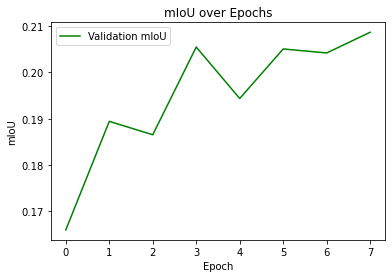

In [ ]:
import datetime
now = datetime.datetime.now()
current_time = now.strftime("%Y%m%d_%H%M%S")
model_save_path = f'{args["model_save_path"]}/{current_time}'
os.mkdir(model_save_path)

plt.plot(train_metrics['epoch_train_losses'], label='Train loss', color='blue') 
plt.plot(train_metrics['epoch_val_losses'], label='Validation loss', color='yellow') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.xticks(range(0, args['epochs']))
plt.title('Loss over Epochs') 
plt.legend()
plt.savefig(f'{model_save_path}/loss_over_epochs.jpg', dpi=300)

plt.clf()
plt.plot(train_metrics['epoch_val_mious'], label='Validation mIoU', color='green') 
plt.xlabel('Epoch') 
plt.ylabel('mIoU') 
plt.xticks(range(0, args['epochs']))
plt.title('mIoU over Epochs') 
plt.legend()
plt.savefig(f'{model_save_path}/iou_over_epochs.jpg', dpi=300)

train_std = train_std.tolist()
train_mean = train_mean.tolist()

eval_args = {'model_load_folder_path': model_save_path,
             'train_std': train_std,
             'train_mean': train_mean,
             'data_source': args['data_source'],
             'test_subset_size': 300,
             'test_batch_size': 4,
             'ignore_label': args['ignore_label'],
             'image_width': args['image_width'],
             'image_height': args['image_height']}
eval_args = json.dumps(eval_args, indent=4)
with open(file=f'{model_save_path}/eval-config.json', mode='w') as f:
    f.write(eval_args)
    
args = json.dumps(args, indent=4)
with open(file=f'{model_save_path}/train_config.json', mode='w') as f:
    f.write(args)


torch.save(model.state_dict(), f'{model_save_path}/deeplabv3_model.pt')
playsound.playsound('finished.mp3')